<a href="https://colab.research.google.com/github/xelav/boosters-digital-reputation/blob/master/boosters_catboost_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

root_dir = "/content/drive/My Drive/boosters"
%cd "{root_dir}"
!pip install catboost

Mounted at /content/drive
/content/drive/My Drive/boosters


In [0]:
!nvidia-smi

Thu Oct  3 14:38:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Prapare data

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import sparse, stats
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from tqdm import tqdm
from catboost import CatBoostClassifier

import datetime
import json
import pickle

In [0]:
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

(8058, 214075)


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


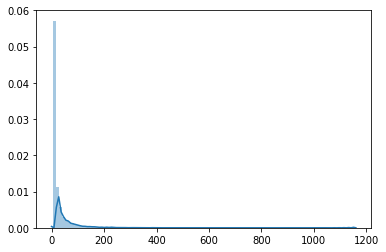

In [0]:
from scipy import sparse

def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    print((len(rows), len(cols)))
    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, np.squeeze(np.asarray(selected_cols))]

    sns.distplot(trimmed_sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        svd = TruncatedSVD(n_components=150)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    return X2, svd

X2_all = X2.append(X2_test)
X2_all, svd = transform_x2(X2_all)

X2 = X2_all[X2_all.id.isin(X1.id)]
df = X1.merge(X2, on='id', how='inner').merge(X3, on='id').merge(Y, on='id')
X = df.iloc[:, :-5]
Y_cls = df.iloc[:, -5:]

X2_test = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test.merge(X2_test, on='id', how='inner').merge(X3_test, on='id')
X_test = df_test

# Grid Search

In [0]:
from scipy.stats import randint, uniform, logistic
from scipy.stats import uniform
import scipy as sp

In [0]:
# specify parameters and distributions to sample from
param_grid  = {"learning_rate":np.logspace(-4,0,5),
              "n_estimators": [300],
             'depth': [3, 4, 5, 6, 7, 8, 9, 10],
             "l2_leaf_reg": np.logspace(-10,3,8),

              # "bootstrap_type": ['Bayesian', 'Bernoulli', 'No'],
              # "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"],
             }

## Bayesian-SymTree

In [0]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

clf = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC", bootstrap_type='Bayesian', grow_policy='SymmetricTree', early_stopping_rounds=10)

grid_search = GridSearchCV(clf, param_grid=param_grid,
                            cv=4, iid=False, verbose=4,
                            scoring=make_scorer(roc_auc_score))

In [0]:
grid_search.fit(X.values, Y['1'].values)

[CV]  depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.01, n_estimators=200, score=0.501, total=  10.9s
[CV] depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.01, n_estimators=200 
[CV]  depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.01, n_estimators=200, score=0.516, total=  11.0s
[CV] depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.1, n_estimators=200 
[CV]  depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.1, n_estimators=200, score=0.509, total=  10.8s
[CV] depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.1, n_estimators=200 
[CV]  depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.1, n_estimators=200, score=0.519, total=  10.9s
[CV] depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.1, n_estimators=200 
[CV]  depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.1, n_estimators=200, score=0.506, total=  11.1s
[CV] depth=9, l2_leaf_reg=5.179474679231213e-07, learning_rate=0.1, n_estimators=20

[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed: 163.2min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f0cd81b2d30>,
             iid=False, n_jobs=None,
             param_grid={'depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'l2_leaf_reg': array([1.00000000e-10, 7.19685673e-09, 5.17947468e-07, 3.72759372e-05,
       2.68269580e-03, 1.93069773e-01, 1.38949549e+01, 1.00000000e+03]),
                         'learning_rate': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'n_estimators': [200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(roc_auc_score), verbose=4)

In [0]:
import pickle
with open('grid_searched.pkl', mode='wb') as f:
    pickle.dump(grid_search, f)

In [0]:
grid_search.cv_results_['mean_test_score'].max()

0.5305582729235234

In [0]:

X.columns

Index([ 'id', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x',
       ...
       '443', '444', '445', '446', '447', '448', '449', '450', '451', '452'],
      dtype='object', length=628)

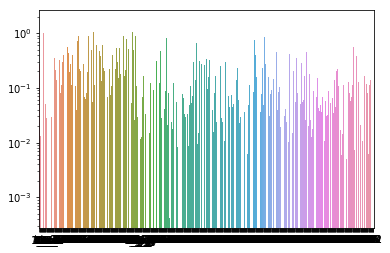

In [0]:
import seaborn as sns

g=sns.barplot(y=grid_search.best_estimator_.get_feature_importance(), x=X.columns)
g.set_yscale('log')

In [0]:
importance = pd.Series(data=grid_search.best_estimator_.get_feature_importance(), index=X.columns)


In [0]:
importance = grid_search.best_estimator_.get_feature_importance(prettified=True)
importance

,Feature Id,Importances
0,6,1.717364
1,26,1.687781
2,623,1.254948
3,109,1.250236
4,96,1.145392
5,175,1.054051
6,102,1.033085
7,8,1.017619
8,0,0.998737
9,74,0.904449


In [0]:
importance['Importances'][:50]

0     1.717364
1     1.687781
2     1.254948
3     1.250236
4     1.145392
5     1.054051
6     1.033085
7     1.017619
8     0.998737
9     0.904449
10    0.891953
11    0.889325
12    0.884376
13    0.882274
14    0.879316
15    0.869093
16    0.864468
17    0.852524
18    0.851578
19    0.816280
20    0.801605
21    0.788949
22    0.739494
23    0.733003
24    0.687997
25    0.666347
26    0.664646
27    0.650353
28    0.628576
29    0.628154
30    0.617749
31    0.607810
32    0.597730
33    0.596635
34    0.578047
35    0.575935
36    0.575600
37    0.569187
38    0.558230
39    0.557987
40    0.557098
41    0.551374
42    0.536781
43    0.536218
44    0.525518
45    0.525282
46    0.520351
47    0.513569
48    0.500628
49    0.495723
Name: Importances, dtype: float64

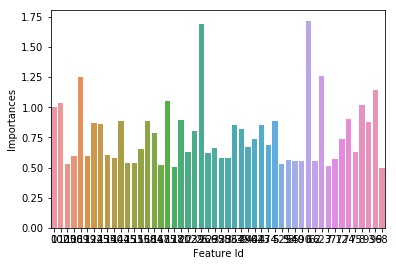

In [0]:
sns.barplot(y=importance['Importances'][:50], x=importance['Feature Id'][:50])

In [0]:
importance.sort_values(ascending=False)[:100]

6_x    1.717364
0      1.687781
448    1.254948
83     1.250236
70     1.145392
149    1.054051
76     1.033085
8_x    1.017619
id     0.998737
48     0.904449
6_y    0.891953
132    0.889325
116    0.884376
5_x    0.882274
67     0.879316
98     0.869093
99     0.864468
248    0.852524
189    0.851578
13     0.816280
64     0.801605
138    0.788949
229    0.739494
46     0.733003
299    0.687997
221    0.666347
120    0.664646
130    0.650353
27     0.628576
49     0.628154
         ...   
88     0.403429
17     0.402643
15     0.401711
269    0.398314
139    0.396246
43     0.395900
231    0.394685
112    0.392353
420    0.389765
232    0.389167
131    0.386506
58     0.384512
89     0.383804
111    0.378065
2      0.366182
77     0.361796
308    0.352768
344    0.352697
3      0.349668
446    0.347325
5_y    0.339202
4      0.336757
40     0.335363
139    0.331349
118    0.330238
12     0.328964
41     0.325987
145    0.324990
440    0.321288
129    0.318457
Length: 100, dtype: floa